<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/predictive_analytics/naive_predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Predictors**

In this notebook we will train and test some baseline models so we can get a sense of how well our main models need to perform. The models will predict price changes for a single lag.

We will try:
- Random Guessing 
- Predict trend based on previous price change


## Get Stock Data

In [ ]:
!git clone https://github.com/itberrios/algotrading

In [22]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


def get_trading_times(df):
    ''' Obtains a cleaned stock price DataFrame, with trading times ranging
        from 9:45 - 4:00
       '''
    
    # ensure that all trading times are sequential, pad missing data with NaNs
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='15min'))
       
    # get regular trading times
    dayofweek = df.index.dayofweek
    hour = df.index.hour
    minute = df.index.minute
    
    df = df.iloc[(dayofweek <= 4)                  # only get M-F
                 & ~((hour == 9) & (minute < 45))  # remove less than 9:45
                 & ((hour >= 9) & (hour <= 16))    # hours 9-16
                 & ~((hour == 16) & (minute > 0))] # remove greater than 16:00
    
    # remove NaNs
    df = df[~df.isna().all(axis=1)]
    
    return df

In [23]:
df = pd.read_csv(r'algotrading/data/raw/AAPL_15min.csv', index_col=0,
                 parse_dates=True, infer_datetime_format=True)
df = get_trading_times(df)

Obtain the first year of data to use as training data

In [ ]:
thresh = 0.1 # dollars
df_train = df.loc['2020-10-01':'2021-10-01']
df_train['price diff'] = df_train['close'].diff()
df_train['price change'] = 1 # price stays the same
df_train['price change'][df_train['price diff'] < -thresh] = 0 # downward price movement
df_train['price change'][df_train['price diff'] > thresh] = 2 # upward prive movement

df_train.dropna(inplace=True)

In [86]:
df_train

,open,high,low,close,volume,price diff,price change
2020-10-01 10:00:00,115.560406,116.316284,114.774886,115.031785,6590610.0,-0.528621,0
2020-10-01 10:15:00,115.021905,115.585108,114.893455,115.268924,6193580.0,0.237138,2
2020-10-01 10:30:00,115.268924,115.496181,115.031785,115.259142,3849310.0,-0.009782,1
2020-10-01 10:45:00,115.263983,115.624631,115.100951,115.417135,3933477.0,0.157993,2
2020-10-01 11:00:00,115.417135,116.266880,115.120712,115.372474,3369518.0,-0.044661,1
...,...,...,...,...,...,...,...
2021-10-01 15:00:00,140.981144,141.388862,140.951311,141.269530,2190037.0,0.293359,2
2021-10-01 15:15:00,141.263265,141.614699,141.199920,141.587749,2125178.0,0.318219,2
2021-10-01 15:30:00,141.592722,141.707082,141.408751,141.458473,2457091.0,-0.129277,0
2021-10-01 15:45:00,141.453501,141.687193,141.339141,141.687193,2557871.0,0.228720,2


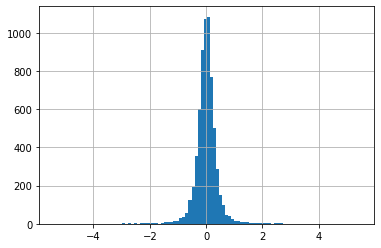

In [87]:
df_train['price diff'].hist(bins=100)

In [88]:
df_train['price change'].value_counts()

2    2264
0    2234
1    2057
Name: price change, dtype: int64

## **Random Guessing**

Since we have a roughly even amount of values in each class, this should acheive roughly 33% accuracy

In [141]:
from sklearn.metrics import accuracy_score

y = df_train['price change'].to_numpy()
y_hat = np.random.randint(0, 3, len(df_train))

accuracy_score(y, y_hat).round(4)

0.3385

## **Use previous price change to predict future price change**

In [142]:
y_hat = df_train['price change'].shift(1).to_numpy()

accuracy_score(y[1:], y_hat[1:]).round(4)

0.3546

Under the assumption that the classes are not heavily imbalanced we may be able to say that a 35% accuracy is the minimum for a trained model.